In [1]:
import sys
import os
# os path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import numpy as np
from numba import njit, prange, cuda, float32, int32
import math
import time
import numba

# Self-defined packages
from obstacle_interface.obs_interface import pack_obstacle_data, precompute_distance_field
from aStarCuda.runner import run_astar_search_numba
from obstacle_interface.obs_interface import pack_obstacle_data


In [2]:
if __name__ == "__main__":
    grid = np.zeros((50, 50, 50), dtype=np.int32)
    start = np.array([0, 0, 0], dtype=np.int32)
    start_v = 0.0
    goal = np.array([40, 40, 40], dtype=np.int32)
    goal_v = 0.0
    base_weights = np.array([[100.0, 5.0, 1.0],
                                    [1.0, 120.0, 1.0],
                                    [1.2, 150.0, 1.0],
                                    [100.0,1.0,1.0]], dtype=np.float32)
    heuristic_weights = np.tile(base_weights, (100, 1)).astype(np.float32) # 4*100 = 400 threads

    velocity_grid = np.array([1.0], dtype=np.float32)
    # env:
    obstacles = [
        {
            "type": "hand",
            "hand_position": (8.0, 8.0, 8.0),
            "length": 6,
            "orientation": (0.0, 0.0, 0.0, 1.0)
        },
        {
            "type": "cuboid",
            "mid_point": (5.0, 5.0, 5.0),
            "length": 3,
            "orientation": (0.0, 0.0, 0.0, 1.0)
        }
    ]
    sq_side_length = 1.0
    cube_centers, cube_dims, cube_rotations, cuboid_centers, cuboid_dims, cuboid_rotations = pack_obstacle_data(obstacles, sq_side_length)
    depth, height, width = grid.shape

    distance_field = precompute_distance_field(depth, height, width,
                                            cube_centers, cube_dims, cube_rotations,
                                            cuboid_centers, cuboid_dims, cuboid_rotations)
    d_start = cuda.to_device(start)
    d_start_v = cuda.to_device(start_v)
    d_goal = cuda.to_device(goal)
    d_goal_v = cuda.to_device(goal_v)
    d_weights = cuda.to_device(heuristic_weights)
    d_velocity_grid = cuda.to_device(velocity_grid)
    d_distance_field = cuda.to_device(distance_field)
    d_grid = cuda.to_device(grid)
    t0 = time.perf_counter()
    results, lengths = run_astar_search_numba(d_grid, d_start, d_start_v, d_goal, d_goal_v, d_weights, d_velocity_grid, d_distance_field, 400, max_time = 10000)
    t1 = time.perf_counter()
    print(f" A-star spend: {(t1-t0)*1000:.3f} ms")

/home/xm/a_star_cuda_python/myenv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/xm/a_star_cuda_python/myenv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/xm/a_star_cuda_python/myenv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/xm/a_star_cuda_python/myenv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/xm/a_star_cuda_python/myenv/lib/python3.10/site-packages/numba

find enough paths


/home/xm/a_star_cuda_python/myenv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


 A-star spend: 3223.568 ms


In [3]:
lengths[:20]

array([ 92, 106, 107,  92,  92, 106, 107,  92,  92, 106, 107,  92,  92,
       106, 107,  92,  92, 106, 107,  92], dtype=int32)

In [4]:
%matplotlib widget

In [5]:
# First 4 Paths
myPlotResluts = results[:4]
myPlotLengths = lengths[:4]

(5.0, 5.0, 5.0)


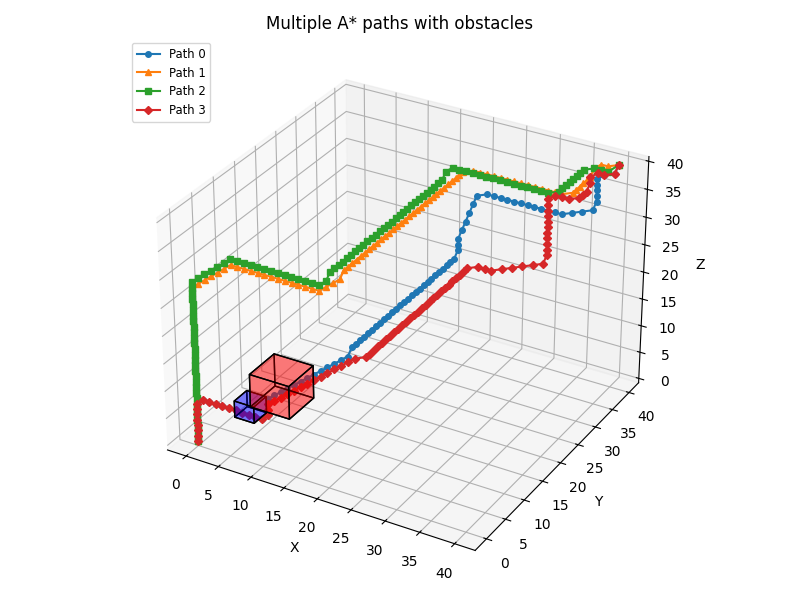

In [6]:
#-----------------------
# Plotting the paths
#-----------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import itertools, matplotlib.colors as mcolors
cmap   = list(mcolors.TABLEAU_COLORS)           # 10 colors
markers = itertools.cycle(['o', '^', 's', 'D']) # 4 markers

def quaternion_to_rotation_matrix(quat):
    x, y, z, w = quat
    r00 = 1 - 2*y*y - 2*z*z
    r01 = 2*x*y - 2*z*w
    r02 = 2*x*z + 2*y*w

    r10 = 2*x*y + 2*z*w
    r11 = 1 - 2*x*x - 2*z*z
    r12 = 2*y*z - 2*x*w

    r20 = 2*x*z - 2*y*w
    r21 = 2*y*z + 2*x*w
    r22 = 1 - 2*x*x - 2*y*y

    return np.array([[r00, r01, r02],
                     [r10, r11, r12],
                     [r20, r21, r22]])

def plot_rotated_cube(center, dims, quat, ax, color='r', alpha=0.3):

    R = quaternion_to_rotation_matrix(quat)
    cx, cy, cz = center
    dx, dy, dz = dims
    hx, hy, hz = dx / 2.0, dy / 2.0, dz / 2.0
    #8 vertices of the cube
    local_vertices = np.array([
        [-hx, -hy, -hz],
        [ hx, -hy, -hz],
        [ hx,  hy, -hz],
        [-hx,  hy, -hz],
        [-hx, -hy,  hz],
        [ hx, -hy,  hz],
        [ hx,  hy,  hz],
        [-hx,  hy,  hz]
    ])

    # rotate the cube
    rotated_vertices = np.dot(local_vertices, R.T)
    # translate the cube to the center
    vertices = rotated_vertices + np.array(center)
    faces = [
        [vertices[i] for i in [0, 1, 2, 3]],
        [vertices[i] for i in [4, 5, 6, 7]],
        [vertices[i] for i in [0, 1, 5, 4]],
        [vertices[i] for i in [2, 3, 7, 6]],
        [vertices[i] for i in [1, 2, 6, 5]],
        [vertices[i] for i in [4, 7, 3, 0]]
    ]

    poly3d = Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=alpha)
    ax.add_collection3d(poly3d)


fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')

for obs in obstacles:
    if obs["type"] == "hand":
        center = obs["hand_position"]
        dims = (obs["length"], obs["length"], obs["length"])
        quat = obs["orientation"]
        plot_rotated_cube(center, dims, quat, ax, color='red', alpha=0.3)
    elif obs["type"] == "cuboid":
        center = obs["mid_point"]
        dims = (obs["length"], obs["length"], obs["length"])
        quat = obs["orientation"]
        print(center)
        plot_rotated_cube(center, dims, quat, ax, color='blue', alpha=0.3)


for idx in range(len(myPlotResluts)):
    L = myPlotLengths[idx]
    if L <= 0:          
        continue
    raw   = np.asarray(myPlotResluts[idx][:L], dtype=np.float64)
    pts   = raw[:, [2,1,0]]                   

    pts   = pts[np.all(pts >= 0, axis=1)]
    if pts.size == 0:
        continue

    color   = cmap[idx % len(cmap)]
    marker  = next(markers)
    ax.plot(pts[:,0], pts[:,1], pts[:,2],
            marker=marker, linewidth=1.5, markersize=4,
            color=color, label=f'Path {idx}')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Multiple A* paths with obstacles')
ax.legend(loc='upper left', fontsize='small')
plt.tight_layout();  plt.show()